In [2]:
from pathlib import Path
from spikeinterface.extractors import read_intan
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from probeinterface import generate_linear_probe
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_probeinterface, read_probeinterface, write_prb
from kilosort import io

In [3]:
filepath = Path(r"D:\recording\2024-05-02-13-37-29\experiment_240502_141247\info.rhd")
recording = read_intan(filepath, stream_id='0')
data_dir = Path(r"D:\recording\2024-05-02-13-37-29\experiment_240502_141247\to_binary")

In [12]:
# NOTE: Data will be saved as np.int16 by default since that is the standard
#       for ephys data. If you need a different data type for whatever reason
#       such as `np.uint16`, be sure to update this.
dtype = np.int16
filename, N, c, s, fs, probe_path = io.spikeinterface_to_binary(
    recording, data_dir, data_name='data.bin', dtype=dtype,
    chunksize=60000, export_probe=True, probe_name='probe.prb'
    )

In [5]:
probe_file = str(data_dir / 'probe.prb')

In [ ]:
probe = generate_linear_probe(32)
probe.set_device_channel_indices(np.arange(32))

probegroup = ProbeGroup()
probegroup.add_probe(probe)
write_prb(probe_file, probegroup)

In [6]:
probe_dict = io.load_probe(probe_file)

In [7]:
from kilosort import run_kilosort

# NOTE: 'n_chan_bin' is a required setting, and should reflect the total number
#       of channels in the binary file. For information on other available
#       settings, see `kilosort.run_kilosort.default_settings`.
settings = {'data_dir': str(data_dir), 'n_chan_bin': 32}

ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = run_kilosort(
    settings=settings, probe=probe_dict)

kilosort.run_kilosort: Sorting D:\recording\2024-05-02-13-37-29\experiment_240502_141247\to_binary\data.bin
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Preprocessing filters computed in  3.65s; total  3.65s
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-computing universal templates from data.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [39]:
import numpy as np
import pandas as pd
from pathlib import Path

# outputs saved to results_dir
results_dir = Path(settings['data_dir']).joinpath('kilosort4')
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

numexpr.utils: Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils: Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils: NumExpr defaulting to 8 threads.
numexpr.utils: NumExpr defaulting to 8 threads.


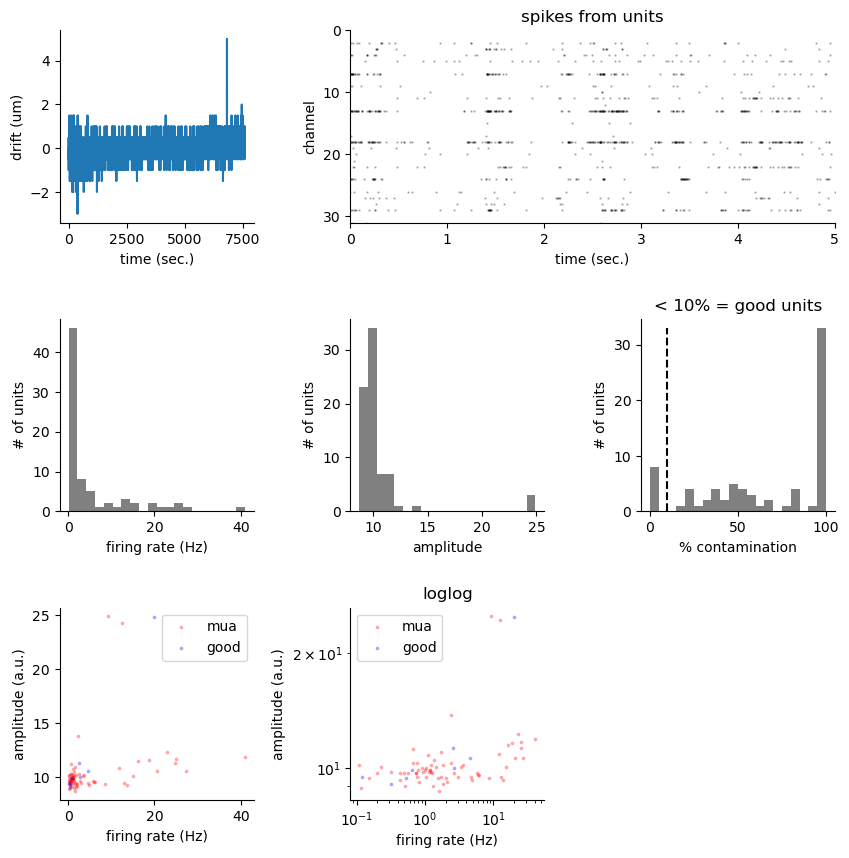

In [40]:
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


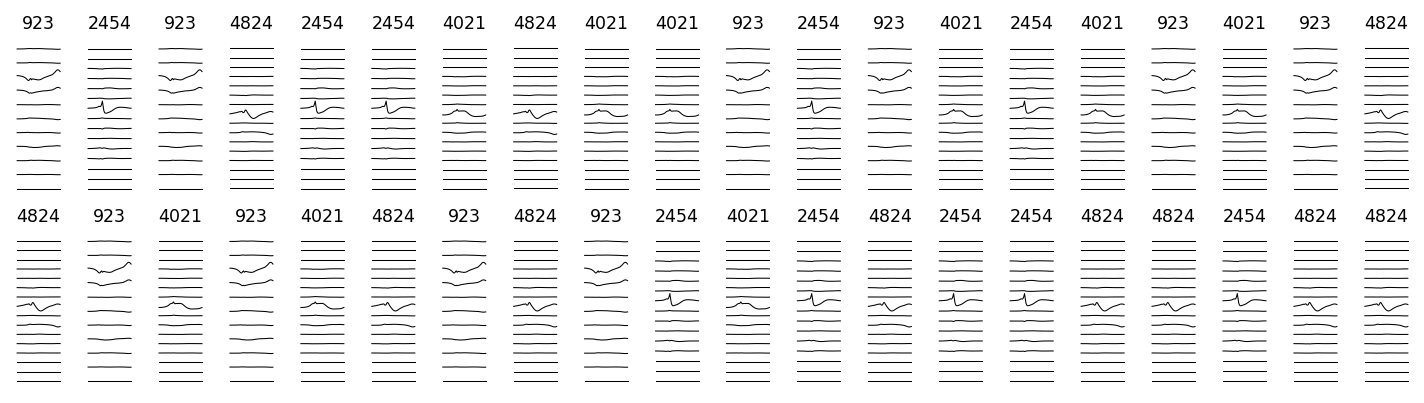

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


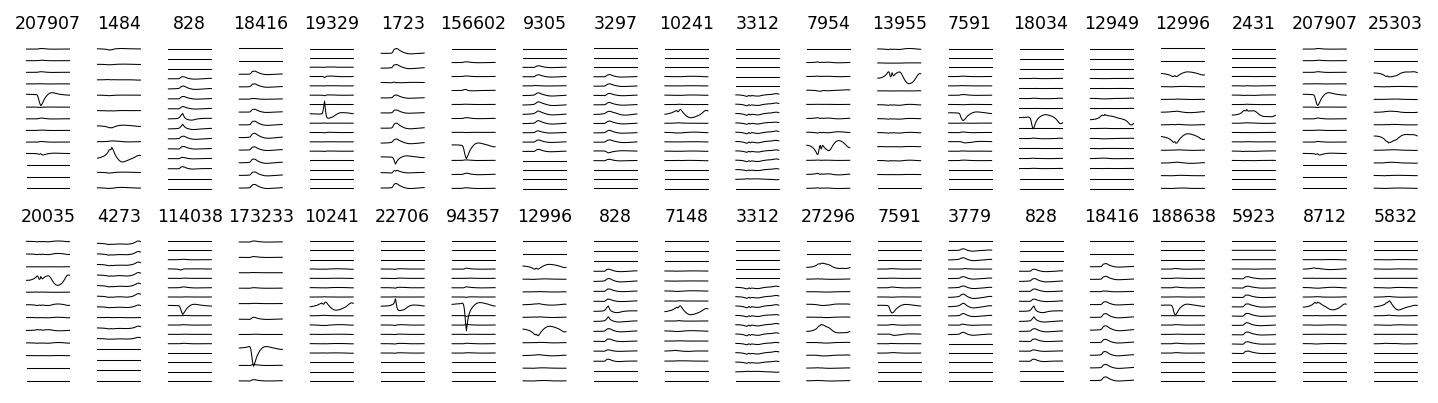

In [41]:
probe = ops['probe']
# x and y position of probe sites
xc, yc = probe['xc'], probe['yc']
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu==wi).sum()

        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()

https://kilosort.readthedocs.io/en/latest/tutorials/basic_example.html